DATASET PARA ANÁLISIS NO PARAMÉTRICO
Clientes analizados: 300
Distribuciones:
- Gasto total: Exponencial (no normal)
- Frecuencia visitas: Poisson
- Satisfacción: Beta (0–10)

TEST DE NORMALIDAD (Shapiro-Wilk)
---------------------------------------------
gasto_total          | Normal: NO | p=2.8664e-21
satisfaccion         | Normal: NO | p=5.7815e-07

ESTADÍSTICAS ROBUSTAS DE GASTO
Segmento   |    Mediana |        IQR |     n
---------------------------------------------
Bronce     | $      120 | $      202 |   144
Plata      | $      199 | $      317 |    93
Oro        | $      268 | $      416 |    63

PRUEBA KRUSKAL-WALLIS
------------------------------
Estadístico H: 17.095
Valor p: 1.9405e-04
Diferencias significativas: SÍ

POST-HOC MANN-WHITNEY U (Bonferroni)
----------------------------------------------------------------------
Comparación          | U          | p-value    | Significativo
----------------------------------------------------------------------
Bronce vs Plata   

<Figure size 800x500 with 0 Axes>

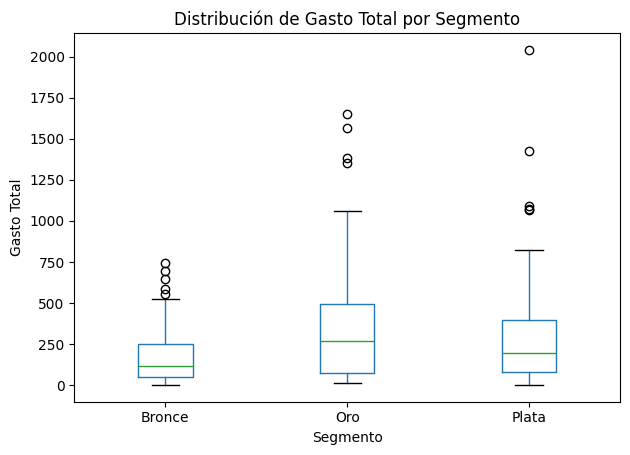


CONCLUSIÓN
Las pruebas no paramétricas son apropiadas porque:
- Los datos no siguen distribuciones normales
- Existen asimetrías y outliers
- Se comparan medianas mediante rangos

Las diferencias entre segmentos son estadísticamente
significativas y robustas frente a violaciones de supuestos.


In [1]:
# ==========================================================
# ANÁLISIS ROBUSTO CON TÉCNICAS NO PARAMÉTRICAS – DÍA 5
# ==========================================================

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations

# ==========================================================
# 1. GENERACIÓN DE DATOS (NO NORMALES)
# ==========================================================
np.random.seed(42)
n_clientes = 300

# Segmentos
segmentos_lista = np.random.choice(
    ['Bronce', 'Plata', 'Oro'],
    n_clientes,
    p=[0.5, 0.3, 0.2]
)

# Gasto total (Exponencial → no normal)
gasto_data = []
for seg in segmentos_lista:
    if seg == 'Oro':
        gasto_data.append(np.random.exponential(scale=450))
    elif seg == 'Plata':
        gasto_data.append(np.random.exponential(scale=250))
    else:
        gasto_data.append(np.random.exponential(scale=150))

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'segmento': segmentos_lista,
    'gasto_total': gasto_data,
    'frecuencia_visitas': np.random.poisson(3, n_clientes),
    'satisfaccion': np.random.beta(5, 2, n_clientes) * 10,
    'antiguedad_dias': np.random.exponential(365, n_clientes).astype(int)
})

print("DATASET PARA ANÁLISIS NO PARAMÉTRICO")
print("=" * 45)
print(f"Clientes analizados: {len(df)}")
print("Distribuciones:")
print("- Gasto total: Exponencial (no normal)")
print("- Frecuencia visitas: Poisson")
print("- Satisfacción: Beta (0–10)")

# ==========================================================
# 2. VERIFICACIÓN DE NO NORMALIDAD
# ==========================================================
print("\nTEST DE NORMALIDAD (Shapiro-Wilk)")
print("-" * 45)

for col in ['gasto_total', 'satisfaccion']:
    stat, p = stats.shapiro(df[col])
    print(f"{col:20} | Normal: {'SÍ' if p > 0.05 else 'NO'} | p={p:.4e}")

# ==========================================================
# 3. ESTADÍSTICA DESCRIPTIVA ROBUSTA
# ==========================================================
orden_segmentos = ['Bronce', 'Plata', 'Oro']
segmentos_dict = {
    seg: df[df['segmento'] == seg]['gasto_total'].values
    for seg in orden_segmentos
}

print("\nESTADÍSTICAS ROBUSTAS DE GASTO")
print("=" * 45)
print(f"{'Segmento':10} | {'Mediana':>10} | {'IQR':>10} | {'n':>5}")
print("-" * 45)

resumen = []

for seg in orden_segmentos:
    datos = segmentos_dict[seg]
    mediana = np.median(datos)
    q25, q75 = np.percentile(datos, [25, 75])
    iqr = q75 - q25
    resumen.append([seg, mediana, iqr, len(datos)])
    print(f"{seg:10} | ${mediana:9.0f} | ${iqr:9.0f} | {len(datos):5}")

resumen_df = pd.DataFrame(
    resumen,
    columns=['segmento', 'mediana_gasto', 'iqr', 'n']
)

# ==========================================================
# 4. PRUEBA KRUSKAL-WALLIS (ANOVA NO PARAMÉTRICO)
# ==========================================================
h_stat, p_kw = stats.kruskal(*segmentos_dict.values())

print("\nPRUEBA KRUSKAL-WALLIS")
print("-" * 30)
print(f"Estadístico H: {h_stat:.3f}")
print(f"Valor p: {p_kw:.4e}")
print(f"Diferencias significativas: {'SÍ' if p_kw < 0.05 else 'NO'}")

# ==========================================================
# 5. POST-HOC MANN-WHITNEY (CON BONFERRONI)
# ==========================================================
posthoc = []

if p_kw < 0.05:
    alpha_bonf = 0.05 / 3
    pares = list(combinations(orden_segmentos, 2))

    print("\nPOST-HOC MANN-WHITNEY U (Bonferroni)")
    print("-" * 70)
    print(f"{'Comparación':<20} | {'U':<10} | {'p-value':<10} | {'Significativo'}")
    print("-" * 70)

    for seg1, seg2 in pares:
        u_stat, p_val = stats.mannwhitneyu(
            segmentos_dict[seg1],
            segmentos_dict[seg2],
            alternative='two-sided'
        )
        sig = "SÍ" if p_val < alpha_bonf else "NO"
        posthoc.append([seg1, seg2, u_stat, p_val, sig])
        print(f"{seg1} vs {seg2:<9} | {u_stat:<10.1f} | {p_val:.4e} | {sig}")

posthoc_df = pd.DataFrame(
    posthoc,
    columns=['grupo_1', 'grupo_2', 'u_stat', 'p_value', 'significativo_bonferroni']
)

# ==========================================================
# 6. VISUALIZACIÓN ROBUSTA
# ==========================================================
plt.figure(figsize=(8, 5))
df.boxplot(column='gasto_total', by='segmento', grid=False)
plt.title("Distribución de Gasto Total por Segmento")
plt.suptitle("")
plt.xlabel("Segmento")
plt.ylabel("Gasto Total")
plt.tight_layout()
plt.savefig("resultados_no_parametricos_dia5.png", dpi=300)
plt.show()

# ==========================================================
# 7. EXPORTACIÓN A EXCEL
# ==========================================================
with pd.ExcelWriter("resultados_no_parametricos_dia5.xlsx") as writer:
    df.to_excel(writer, sheet_name="dataset_original", index=False)
    resumen_df.to_excel(writer, sheet_name="estadisticas_robustas", index=False)
    posthoc_df.to_excel(writer, sheet_name="posthoc_mann_whitney", index=False)

# ==========================================================
# 8. CONCLUSIÓN
# ==========================================================
print("\nCONCLUSIÓN")
print("=" * 40)
print(
    "Las pruebas no paramétricas son apropiadas porque:\n"
    "- Los datos no siguen distribuciones normales\n"
    "- Existen asimetrías y outliers\n"
    "- Se comparan medianas mediante rangos\n\n"
    "Las diferencias entre segmentos son estadísticamente\n"
    "significativas y robustas frente a violaciones de supuestos."
)